# DMart Product Classification - ROC/AUC Analysis

This notebook provides detailed ROC/AUC analysis for the DMart product classification models:
- Logistic Regression
- Random Forest
- XGBoost

We'll visualize ROC curves, calculate AUC scores, and display confusion matrices for each model.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_curve, 
    auc, 
    confusion_matrix, 
    classification_report,
    accuracy_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load and Prepare Data

In [4]:
# Load the DMart dataset
df = pd.read_csv('DMart.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (5189, 9)

Columns: ['Name', 'Brand', 'Price', 'DiscountedPrice', 'Category', 'SubCategory', 'Quantity', 'Description', 'BreadCrumbs']

First few rows:


,Name,Brand,Price,DiscountedPrice,Category,SubCategory,Quantity,Description,BreadCrumbs
0,Premia Badam (Almonds),Premia,451.0,329.0,Grocery,Grocery/Dry Fruits,500 gm,India,Grocery > Grocery/Dry Fruits
1,Premia Badam (Almonds),Premia,109.0,85.0,Grocery,Grocery/Dry Fruits,100 gm,India,Grocery > Grocery/Dry Fruits
2,Premia Badam (Almonds),Premia,202.0,175.0,Grocery,Grocery/Dry Fruits,200 gm,India,Grocery > Grocery/Dry Fruits
3,Nutraj California Almonds (Badam),Nutraj,599.0,349.0,Grocery,Dry Fruits,500 gm,USA,Grocery > Dry Fruits
4,Nutraj California Almonds (Badam),Nutraj,1549.0,659.0,Grocery,Dry Fruits,1 kg,USA,Grocery > Dry Fruits


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5189 entries, 0 to 5188
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             5188 non-null   object 
 1   Brand            4789 non-null   object 
 2   Price            5188 non-null   float64
 3   DiscountedPrice  5188 non-null   float64
 4   Category         5186 non-null   object 
 5   SubCategory      5186 non-null   object 
 6   Quantity         5188 non-null   object 
 7   Description      5187 non-null   object 
 8   BreadCrumbs      5186 non-null   object 
dtypes: float64(2), object(7)
memory usage: 365.0+ KB


Category distribution:
Category
Personal Care                    1234
Packaged Food                    1125
Home & Kitchen                    880
Grocery                           840
Dairy & Beverages                 429
Specials                          187
Clothing & Accessories             97
Fruits & Vegetables                78
School Supplies                    69
Appliances                         53
Beauty & Cosmetics                 46
Raincoat                           33
DMart Grocery                      31
Plant Container                    23
Tableware                          18
Backpacks                          13
Zebronics                           5
Motorbike Helmets                   4
Baby & Kids                         4
Kitchen Aprons                      3
Geep                                3
Computer Accessories                2
Butterfly                           2
Joyo Plastics                       2
Wonderchef                          1
Water Purifiers & 

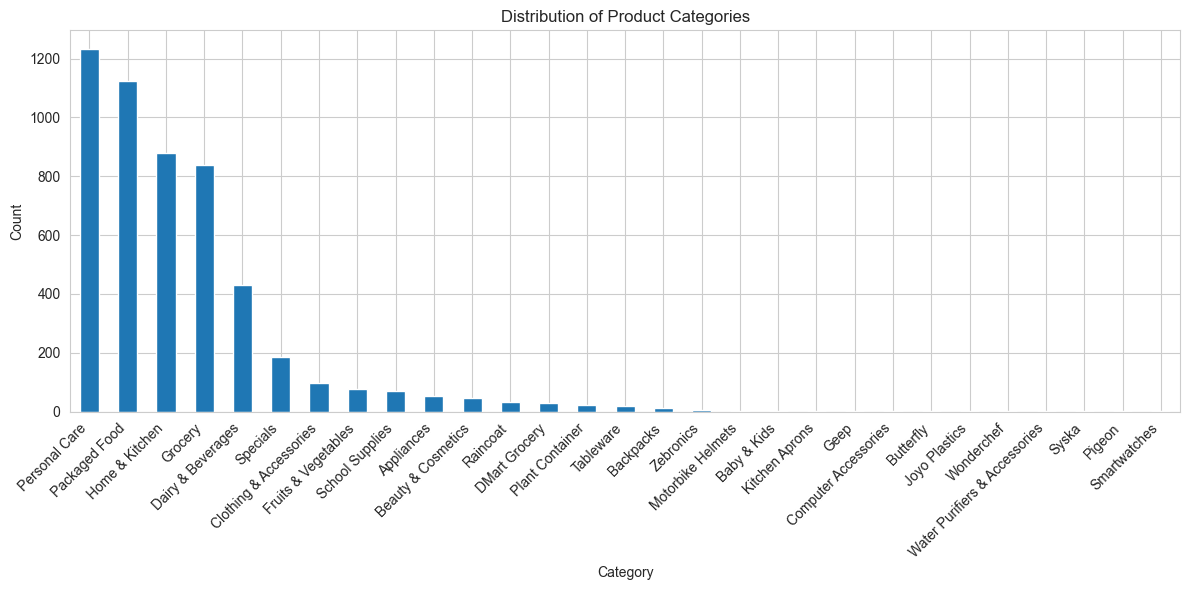

In [6]:
# Check target variable distribution
print("Category distribution:")
print(df['Category'].value_counts())

plt.figure(figsize=(12, 6))
df['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Product Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [ ]:
# Handle missing values
df = df.dropna()

# Parse quantity to extract numeric value and unit
def parse_quantity(qty_str):
    if pd.isna(qty_str):
        return 0, 'unknown'
    
    qty_str = str(qty_str).lower().strip()
    
    # Extract numeric value
    import re
    numbers = re.findall(r'\d+\.?\d*', qty_str)
    value = float(numbers[0]) if numbers else 0
    
    # Determine unit
    if 'kg' in qty_str:
        return value * 1000, 'g'  # Convert to grams
    elif 'g' in qty_str:
        return value, 'g'
    elif 'l' in qty_str:
        return value * 1000, 'ml'  # Convert to ml
    elif 'ml' in qty_str:
        return value, 'ml'
    else:
        return value, 'unit'

# Apply quantity parsing
df[['QuantityValue', 'QuantityUnit']] = df['Quantity'].apply(
    lambda x: pd.Series(parse_quantity(x))
)

# Calculate discount percentage
df['DiscountPercent'] = ((df['Price'] - df['DiscountedPrice']) / df['Price'] * 100).fillna(0)

print("Preprocessing completed!")
print(f"\nNew features created: QuantityValue, QuantityUnit, DiscountPercent")
df.head()

In [ ]:
# Prepare features
# TF-IDF for product names
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
name_features = tfidf.fit_transform(df['Name'].fillna('')).toarray()

# Encode categorical features
le_brand = LabelEncoder()
le_unit = LabelEncoder()

df['Brand_Encoded'] = le_brand.fit_transform(df['Brand'].fillna('Unknown'))
df['Unit_Encoded'] = le_unit.fit_transform(df['QuantityUnit'])

# Combine all features
numerical_features = df[[
    'Price', 'DiscountedPrice', 'QuantityValue', 
    'Brand_Encoded', 'Unit_Encoded', 'DiscountPercent'
]].values

X = np.hstack([name_features, numerical_features])

# Encode target variable
le_category = LabelEncoder()
y = le_category.fit_transform(df['Category'])

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of classes: {len(le_category.classes_)}")
print(f"Classes: {le_category.classes_}")

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

## 3. Train Models

In [ ]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

In [ ]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

In [ ]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

## 4. ROC Curves and AUC Scores

In [ ]:
# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

print(f"Number of classes: {n_classes}")
print(f"Class names: {le_category.classes_}")

In [ ]:
# Function to plot ROC curves for multi-class classification
def plot_multiclass_roc(y_test_bin, y_pred_proba, model_name, class_names):
    """
    Plot ROC curves for multi-class classification
    """
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot ROC curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 
                    'purple', 'brown', 'pink', 'gray', 'olive'])
    
    for i, color in zip(range(min(n_classes, 10)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
            color='deeppink', linestyle=':', linewidth=4)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc

### 4.1 Logistic Regression ROC/AUC

In [ ]:
lr_auc = plot_multiclass_roc(y_test_bin, lr_pred_proba, 
                              'Logistic Regression', le_category.classes_)

print("\nLogistic Regression - AUC Scores:")
print(f"Micro-average AUC: {lr_auc['micro']:.4f}")
print("\nPer-class AUC scores:")
for i, class_name in enumerate(le_category.classes_[:10]):
    print(f"  {class_name}: {lr_auc[i]:.4f}")

### 4.2 Random Forest ROC/AUC

In [ ]:
rf_auc = plot_multiclass_roc(y_test_bin, rf_pred_proba, 
                              'Random Forest', le_category.classes_)

print("\nRandom Forest - AUC Scores:")
print(f"Micro-average AUC: {rf_auc['micro']:.4f}")
print("\nPer-class AUC scores:")
for i, class_name in enumerate(le_category.classes_[:10]):
    print(f"  {class_name}: {rf_auc[i]:.4f}")

### 4.3 XGBoost ROC/AUC

In [ ]:
xgb_auc = plot_multiclass_roc(y_test_bin, xgb_pred_proba, 
                               'XGBoost', le_category.classes_)

print("\nXGBoost - AUC Scores:")
print(f"Micro-average AUC: {xgb_auc['micro']:.4f}")
print("\nPer-class AUC scores:")
for i, class_name in enumerate(le_category.classes_[:10]):
    print(f"  {class_name}: {xgb_auc[i]:.4f}")

## 5. Confusion Matrices

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Plot confusion matrix with better visualization
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

### 5.1 Logistic Regression Confusion Matrix

In [ ]:
lr_cm = plot_confusion_matrix(y_test, lr_pred, le_category.classes_, 
                               'Logistic Regression')

### 5.2 Random Forest Confusion Matrix

In [ ]:
rf_cm = plot_confusion_matrix(y_test, rf_pred, le_category.classes_, 
                               'Random Forest')

### 5.3 XGBoost Confusion Matrix

In [ ]:
xgb_cm = plot_confusion_matrix(y_test, xgb_pred, le_category.classes_, 
                                'XGBoost')

## 6. Classification Reports

In [ ]:
print("=" * 80)
print("LOGISTIC REGRESSION - Classification Report")
print("=" * 80)
print(classification_report(y_test, lr_pred, target_names=le_category.classes_))

In [ ]:
print("=" * 80)
print("RANDOM FOREST - Classification Report")
print("=" * 80)
print(classification_report(y_test, rf_pred, target_names=le_category.classes_))

In [ ]:
print("=" * 80)
print("XGBOOST - Classification Report")
print("=" * 80)
print(classification_report(y_test, xgb_pred, target_names=le_category.classes_))

## 7. Model Comparison Summary

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'Micro-avg AUC': [lr_auc['micro'], rf_auc['micro'], xgb_auc['micro']]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# AUC comparison
axes[1].bar(comparison_df['Model'], comparison_df['Micro-avg AUC'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Model AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Micro-average AUC', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Micro-avg AUC']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Conclusion

This notebook provides comprehensive ROC/AUC analysis for the DMart product classification models. Key findings:

1. **ROC Curves**: Show the trade-off between true positive rate and false positive rate for each class
2. **AUC Scores**: Quantify the overall performance of each model across all classes
3. **Confusion Matrices**: Reveal which categories are most commonly confused
4. **Classification Reports**: Provide detailed precision, recall, and F1-scores for each category

The model with the highest accuracy and AUC score is recommended for deployment.